*Examples have been upgraded to work with scikit-learn 0.23.1.*  Also support code has been pasted in to avoid ref to support.py, making it work on colab as standalone notebook.

## Setup

In [13]:
import numpy as np
import pandas as pd
from typing import Mapping, List, Tuple
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
    load_breast_cancer, load_diabetes
from  matplotlib.collections import LineCollection
import matplotlib.patches as mpatches
import time
from pandas.api.types import is_string_dtype, is_object_dtype, is_categorical_dtype, is_bool_dtype
from sklearn.inspection import partial_dependence, plot_partial_dependence

!pip install -q -U pdpbox
!pip install -q -U rfpimp
!pip install -q -U stratx

from pdpbox import pdp
from rfpimp import *
from scipy.integrate import cumtrapz
from stratx import *

#%config InlineBackend.figure_formats = ['svg','png']

In [14]:
#from support import *  # CHECK OUT THE support.py FILE IN THIS DIR

In [15]:
datadir = "data"

# Synthetic data to check whether StratPD captures relationships

Partial dependence plots of $n=2000$ data generated from noiseless $y = x_1^2 + x_1 x_2 + 5 x_1 sin(3 x_2) + 10$ where $x_1,x_2,x_3 \sim U(0,10)$ and $x_3$ does not affect $y$.

In [16]:
def synthetic_interaction_data(n, yintercept = 10):
    df = pd.DataFrame()
    df[f'x1'] = np.random.random(size=n)*10
    df[f'x2'] = np.random.random(size=n)*10
    df[f'x3'] = np.random.random(size=n)*10
    df['y'] = df['x1']**2 + df['x1']*df['x2'] + 5*df['x1']*np.sin(3*df['x2'])  + yintercept
    return df

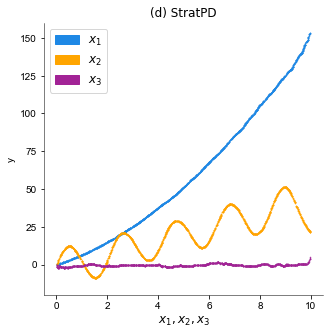

In [17]:
n = 2000
df = synthetic_interaction_data(n)

X, y = df[['x1', 'x2', 'x3']].copy(), df['y'].copy()
X1 = X.iloc[:, 0]
X2 = X.iloc[:, 1]
X3 = X.iloc[:, 2] # UNUSED in y

fig, ax = plt.subplots(1,1,figsize=(5,5))

x1_color = '#1E88E5'
x2_color = 'orange'
x3_color = '#A22396'

plot_stratpd(X, y, "x1", "y", ax=ax, pdp_marker_size=1,
             pdp_marker_color=x1_color,
             show_x_counts=False, n_trials=1, show_slope_lines=False)
plot_stratpd(X, y, "x2", "y", ax=ax, pdp_marker_size=1,
             pdp_marker_color=x2_color,
             show_x_counts=False, n_trials=1, show_slope_lines=False)
plot_stratpd(X, y, "x3", "y", ax=ax, pdp_marker_size=1,
             pdp_marker_color=x3_color,
             show_x_counts=False, n_trials=1, show_slope_lines=False)
ax.set_xticks([0,2,4,6,8,10])
ax.set_ylim(-20,160)
ax.set_yticks([0, 25, 50, 75, 100, 125, 150])
ax.set_xlabel("$x_1, x_2, x_3$", fontsize=12)
ax.set_title("(d) StratPD")
ax.spines['top'].set_linewidth(.5)
ax.spines['right'].set_linewidth(.5)
ax.spines['left'].set_linewidth(.5)
ax.spines['bottom'].set_linewidth(.5)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
x1_patch = mpatches.Patch(color=x1_color, label='$x_1$')
x2_patch = mpatches.Patch(color=x2_color, label='$x_2$')
x3_patch = mpatches.Patch(color=x3_color, label='$x_3$')
ax.legend(handles=[x1_patch,x2_patch,x3_patch], fontsize=12)
plt.show()

# The effect of noise

Curves for noisy quadratics generated from $y = x_1^2 + x_2 + 10 + \epsilon$ where $\epsilon \sim N(0,\sigma)$ $\epsilon$ and, at $\sigma=2$, 95\% of the noise falls within [0,4] (since $2\sigma = 4$), meaning that the signal-to-noise ratio is at best 1-to-1 for $x_1^2$ in $[-2,2]$.  The most noisy version on far right is highly variable actually.

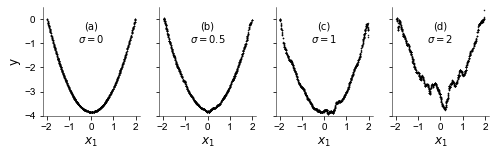

In [18]:
def noisy_poly_data(n, sd=1.0):
    x1 = np.random.uniform(-2, 2, size=n)
    x2 = np.random.uniform(-2, 2, size=n)

    y = x1 ** 2 + x2 + 10 + np.random.normal(0, sd, size=n)
    df = pd.DataFrame()
    df['x1'] = x1
    df['x2'] = x2
    df['y'] = y
    return df

n = 1000
fig, axes = plt.subplots(1, 4, figsize=(8, 2), sharey=True)
sds = [0,.5,1,2]
for i,sd in enumerate(sds):
    df = noisy_poly_data(n=n, sd=sd)
    X = df.drop('y', axis=1)
    y = df['y']
    plot_stratpd(X, y, 'x1', 'y',
                 show_ylabel=False,
                 pdp_marker_size=1,
                 show_x_counts=False,
                 ax=axes[i], yrange=(-4, .5))
axes[0].set_ylabel("y", fontsize=12)

for i,(ax,which) in enumerate(zip(axes,['(a)','(b)','(c)','(d)'])):
    ax.text(0, -1, f"{which}\n$\sigma = {sds[i]}$", horizontalalignment='center')
    ax.set_xlabel('$x_1$', fontsize=12)
    ax.set_xticks([-2,-1,0,1,2])
    
plt.show()

# NYC apt rent

*Data use rules prevent me from storing this data in this repo*. Download the data set from Kaggle. (You must be a registered Kaggle user and must be logged in.) Go to the Kaggle [data page](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data) and save `train.json` into the `data` directory underneath this notebook. 

In [19]:
import os

def load_rent(n:int=None, clean_prices=True):
    global datadir
    if not os.path.exists(datadir):
        datadir = "data"
    msg = """Download train.json from https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data
    and save into data subdir."""
    if not os.path.exists(f"{datadir}/train.json"):
        raise ValueError(msg)

    df = pd.read_json(f'{datadir}/train.json')
    print(f"Rent has {len(df)} records")

    # Create ideal numeric data set w/o outliers etc...

    if clean_prices:
        df = df[(df.price > 1_000) & (df.price < 10_000)]

    df = df[df.bathrooms <= 6]  # There's almost no data for 6 and above with small sample
    df = df[(df.longitude != 0) | (df.latitude != 0)]
    df = df[(df['latitude'] > 40.55) & (df['latitude'] < 40.94) &
            (df['longitude'] > -74.1) & (df['longitude'] < -73.67)]
    df['interest_level'] = df['interest_level'].map({'low': 1, 'medium': 2, 'high': 3})
    df["num_desc_words"] = df["description"].apply(lambda x: len(x.split()))
    df["num_features"] = df["features"].apply(lambda x: len(x))
    df["num_photos"] = df["photos"].apply(lambda x: len(x))

    # The numeric stratpd can't extract data too well when so many data points sit
    # on same values; flip it to integers from flops like 1.5 baths; can consider
    # categorical nominal or as ordinal but it stratpd ignores lots of data as ordinal
    # so best to use catstratpd
    uniq_b = np.unique(df['bathrooms'])
    df['bathrooms'] = df['bathrooms'].map({v: i + 1 for i, v in enumerate(uniq_b)})

    hoods = {
        "hells": [40.7622, -73.9924],
        "astoria": [40.7796684, -73.9215888],
        "Evillage": [40.723163774, -73.984829394],
        "Wvillage": [40.73578, -74.00357],
        "LowerEast": [40.715033, -73.9842724],
        "UpperEast": [40.768163594, -73.959329496],
        "ParkSlope": [40.672404, -73.977063],
        "Prospect Park": [40.93704, -74.17431],
        "Crown Heights": [40.657830702, -73.940162906],
        "financial": [40.703830518, -74.005666644],
        "brooklynheights": [40.7022621909, -73.9871760513],
        "gowanus": [40.673, -73.997]
    }
    for hood, loc in hoods.items():
        # compute manhattan distance
        df[hood] = np.abs(df.latitude - loc[0]) + np.abs(df.longitude - loc[1])
        df[hood] *= 1000 # GPS range is very tight so distances are very small. bump up
    hoodfeatures = list(hoods.keys())

    if n is not None:
        howmany = min(n, len(df))
        df = df.sort_values(by='created').sample(howmany, replace=False)
    # df = df.sort_values(by='created')  # time-sensitive dataset
    # df = df.iloc[-n:]

    df_rent = df[['bedrooms', 'bathrooms', 'latitude', 'longitude', 'price',
                  'interest_level']+
                 hoodfeatures+
                 ['num_photos', 'num_desc_words', 'num_features']]
    # print(df_rent.head(3))

    X = df_rent.drop('price', axis=1)
    y = df_rent['price']
    return X, y

In [20]:
n = 10_000
X, y = load_rent(n=n)
X.head()

Rent has 49352 records


,bedrooms,bathrooms,latitude,longitude,interest_level,hells,astoria,Evillage,Wvillage,LowerEast,UpperEast,ParkSlope,Prospect Park,Crown Heights,financial,brooklynheights,gowanus,num_photos,num_desc_words,num_features
37937,2,4,40.7110,-74.0072,1,66.0,154.2796,34.534380,28.41,26.9606,105.034098,68.733,393.15,120.206392,8.702838,28.761758,48.2,6,48,11
76440,3,2,40.7027,-73.9200,1,131.9,78.5572,85.293168,116.65,76.6054,104.793090,87.359,488.65,65.032204,86.797162,67.613860,106.7,11,51,3
115150,1,2,40.7535,-73.9648,2,36.3,69.3796,50.365620,56.49,57.9394,20.134098,93.359,393.05,120.306392,90.536126,73.613860,112.7,5,58,7
70331,3,4,40.7561,-73.9965,2,10.2,98.4796,44.606832,27.39,53.2946,49.234098,103.133,358.75,154.606392,61.436126,63.161758,83.6,7,143,14
122651,2,4,40.7606,-73.9963,1,5.5,93.7796,48.906832,32.09,57.5946,44.534098,107.433,354.45,158.906392,66.136126,67.461758,88.3,5,80,5


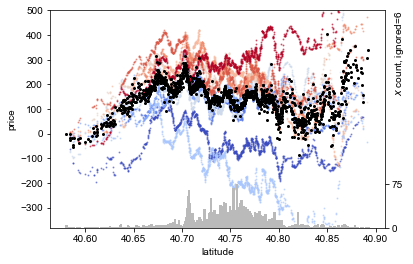

In [21]:
# This one is highly variable depending on subset we choose.
plot_stratpd(X, y, 'latitude', 'price', n_trials = 10, yrange=(-200,500))
plt.show()

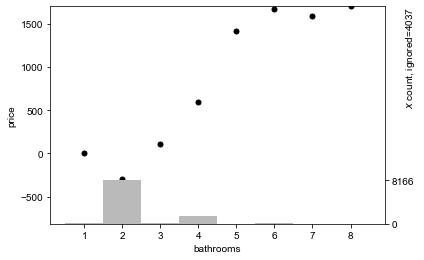

In [22]:
plot_stratpd(X, y, 'bathrooms', 'price', pdp_marker_size=10)
plt.show()

# Bulldozer sales

*Data use rules prevent me from storing this data in this repo*. Download the data set from Kaggle. (You must be a registered Kaggle user and must be logged in.) Go to the Kaggle [Blue Book for Bulldozers](https://www.kaggle.com/c/bluebook-for-bulldozers/data) and save `Train.csv` into the `data` directory underneath this notebook.

The raw csv is superslow to load, but feather is fast so load it'll load first time as csv then save as feather, which loads next time.

In [32]:
from sklearn.utils import resample

def fix_missing_num(df, colname):
    df[colname+'_na'] = pd.isnull(df[colname]).astype(int)
    df[colname].fillna(df[colname].median(), inplace=True)

def df_split_dates(df,colname):
    df["saleyear"] = df[colname].dt.year
    df["salemonth"] = df[colname].dt.month
    df["saleday"] = df[colname].dt.day
    df["saledayofweek"] = df[colname].dt.dayofweek
    df["saledayofyear"] = df[colname].dt.dayofyear
    df[colname] = df[colname].astype(np.int64) # convert to seconds since 1970
    
def load_bulldozer(n):
    global datadir
    if not os.path.exists(datadir):
        datadir = "data"

    msg = "Download Train.csv data from https://www.kaggle.com/c/bluebook-for-bulldozers/data and save in data subdir"
    if os.path.exists(f"{datadir}/bulldozer-train-all.feather"):
        print("Loading cached version...")
        df = pd.read_feather(f"{datadir}/bulldozer-train-all.feather")
    elif not os.path.exists(f"{datadir}/Train.csv"):
        raise ValueError(msg)
    else:
        dtypes = {col: str for col in
                  ['fiModelSeries', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow']}
        df = pd.read_csv(f'{datadir}/Train.csv', dtype=dtypes, parse_dates=['saledate'])  # 35s load
        df = df.sort_values('saledate')
        df = df.reset_index(drop=True)
        df.to_feather(f"{datadir}/bulldozer-train-all.feather")

    df['MachineHours'] = df['MachineHoursCurrentMeter']  # shorten name
    df.loc[df.eval("MachineHours==0"), 'MachineHours'] = np.nan
    fix_missing_num(df, 'MachineHours')

    # df.loc[df.YearMade < 1950, 'YearMade'] = np.nan
    # fix_missing_num(df, 'YearMade')
    df = df.loc[df.YearMade > 1950].copy()
    df_split_dates(df, 'saledate')
    df['age'] = df['saleyear'] - df['YearMade']
    df['YearMade'] = df['YearMade'].astype(int)
    sizes = {None: 0, 'Mini': 1, 'Compact': 1, 'Small': 2, 'Medium': 3,
             'Large / Medium': 4, 'Large': 5}
    df['ProductSize'] = df['ProductSize'].map(sizes).values

    df['Enclosure'] = df['Enclosure'].replace('EROPS w AC', 'EROPS AC')
    df['Enclosure'] = df['Enclosure'].replace('None or Unspecified', np.nan)
    df['Enclosure'] = df['Enclosure'].replace('NO ROPS', np.nan)
    df['AC'] = df['Enclosure'].fillna('').str.contains('AC')
    df['AC'] = df['AC'].astype(int)
    # print(df.columns)

    # del df['SalesID']  # unique sales ID so not generalizer (OLS clearly overfits)
    # delete MachineID as it has inconsistencies and errors per Kaggle

    features = ['ModelID',
                'datasource', 'YearMade',
                # some missing values but use anyway:
                'auctioneerID',
                'MachineHours',
                'age',
                'AC',
                'ProductSize',
                'saleyear', 'salemonth', 'saleday', 'saledayofweek', 'saledayofyear'
                ]

    X = df[features]
    X = X.fillna(0)  # flip missing numeric values to zeros
    y = df['SalePrice']

    # Most recent timeseries data is more relevant so get big recent chunk
    # then we can sample from that to get n
    X = X.iloc[-50_000:]
    y = y.iloc[-50_000:]

    print(f"Bulldozer has {len(df)} records")

    idxs = resample(range(50_000), n_samples=n, replace=False, )
    X, y = X.iloc[idxs], y.iloc[idxs]

    return X, y

In [33]:
! pip install -q pyarrow
X, y = load_bulldozer(10_000)
X.head()

Loading cached version...
Bulldozer has 362781 records


,ModelID,datasource,YearMade,auctioneerID,MachineHours,age,AC,ProductSize,saleyear,salemonth,saleday,saledayofweek,saledayofyear
350593,14377,121,2003,3.0,12273.0,7,1,4,2010,6,24,3,175
392640,5517,172,2000,1.0,3031.0,11,0,0,2011,9,28,2,271
361580,17313,149,2005,2.0,3138.0,5,1,0,2010,11,6,5,310
362302,6633,132,2001,12.0,3138.0,9,0,0,2010,11,17,2,321
363236,1453,149,2004,26.0,3138.0,6,1,3,2010,12,2,3,336


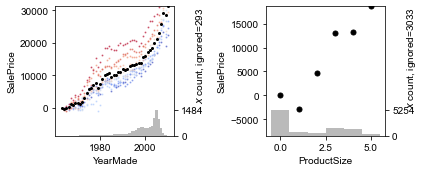

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(6, 2.5))

plot_stratpd(X, y, colname='YearMade', targetname='SalePrice', ax=axes[0], n_trials=10)
plot_stratpd(X, y, colname='ProductSize', targetname='SalePrice', ax=axes[1], pdp_marker_size=10)

plt.tight_layout()
plt.show()

# Synthetic human weight data

We synthesized a body weight data set generated by the following equation with nontrivial codependencies between variables: 

<img src="weight_equation.png" width="600">

In [35]:
def toy_weight_data(n):
    df = pd.DataFrame()
    nmen = n // 2 # 50/50 men/women
    nwomen = n // 2
    df['sex'] = ['M'] * nmen + ['F'] * nwomen
    df.loc[df['sex'] == 'F', 'pregnant'] = np.random.randint(0, 2, size=(nwomen,))
    df.loc[df['sex'] == 'M', 'pregnant'] = 0
    df.loc[df['sex'] == 'M', 'height'] = 5 * 12 + 8 + np.random.uniform(-7, +8,
                                                                        size=(nmen,))
    df.loc[df['sex'] == 'F', 'height'] = 5 * 12 + 5 + np.random.uniform(-4.5, +5,
                                                                        size=(nwomen,))
    df.loc[df['sex'] == 'M', 'education'] = 10 + np.random.randint(0, 8, size=nmen)
    df.loc[df['sex'] == 'F', 'education'] = 12 + np.random.randint(0, 8, size=nwomen)
    df['weight'] = 120 \
                   + (df['height'] - df['height'].min()) * 10 \
                   + df['pregnant'] * 40 \
                   - df['education'] * 1.5
    df['pregnant'] = df['pregnant'].astype(bool)
    df['education'] = df['education'].astype(int)
    eqn = "y = 120 + 10(x_{height} - min(x_{height})) + 30x_{pregnant} - 1.5x_{education}"

    df['pregnant'] = df['pregnant'].astype(int)
    df['sex'] = df['sex'].map({'M': 0, 'F': 1}).astype(int)
    X = df.drop('weight', axis=1)
    y = df['weight']

    return X, y, df, eqn

In [36]:
X, y, df, eqn = toy_weight_data(6)
df.head(3)

,sex,pregnant,height,education,weight
0,0,0,70.775469,12,190.614836
1,0,0,68.297839,14,162.838530
2,0,0,68.459767,14,164.457810


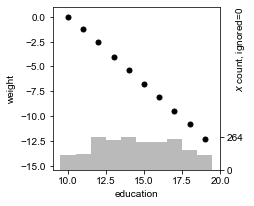

In [37]:
X, y, df, eqn = toy_weight_data(2000)

fig, ax = plt.subplots(1, 1, figsize=(3,3))
plot_stratpd(X, y, 'education', 'weight', ax=ax,
             yrange=(-12, 1),
             show_x_counts=True,
             pdp_marker_size=10)
plt.show()

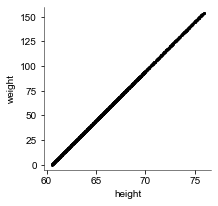

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(3,3))
plot_stratpd(X, y, 'height', 'weight', ax=ax,
             show_x_counts=False,
             yrange=(-5,160),
             pdp_marker_size=3)
plt.show()

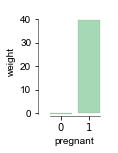

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(1.3,2))
plot_catstratpd(X, y, 'pregnant', 'weight', ax=ax,
                show_x_counts=False,
                catnames={0:'False',1:'True'},
                yrange=(-1, 45),
                )
plt.show()

# Toy weather data with sine curve

In [47]:
def toy_weather_data():
    df_yr1 = toy_weather_data_1yr()
    df_yr1['year'] = 1980
    df_yr2 = toy_weather_data_1yr()
    df_yr2['year'] = 1981
    df_yr3 = toy_weather_data_1yr()
    df_yr3['year'] = 1982
    df_raw = pd.concat([df_yr1, df_yr2, df_yr3], axis=0)
    df = df_raw.copy()
    return df

def toy_weather_data_1yr():
    # def temp(x): return 10*np.sin((2*x + 365) * (np.pi) / 365)
    def temp(x): return 10*np.sin(((2/365)*np.pi*x + np.pi))

    def noise(state):
        # noise_per_state = {'CA':2, 'CO':4, 'AZ':7, 'WA':2, 'NV':5}
        return np.random.normal(0, 4, sum(df['state'] == state))

    df = pd.DataFrame()
    df['dayofyear'] = range(1, 365 + 1)
    df['state'] = np.random.choice(['CA', 'CO', 'AZ', 'WA', 'NV'], len(df))
    df['temperature'] = temp(df['dayofyear'])
    df.loc[df['state'] == 'CA', 'temperature'] = \
        70 + df.loc[df['state'] == 'CA', 'temperature'] + noise('CA')
    df.loc[df['state'] == 'CO', 'temperature'] = \
        40 + df.loc[df['state'] == 'CO', 'temperature'] + noise('CO')
    df.loc[df['state'] == 'AZ', 'temperature'] = \
        90 + df.loc[df['state'] == 'AZ', 'temperature'] + noise('AZ')
    df.loc[df['state'] == 'WA', 'temperature'] = \
        60 + df.loc[df['state'] == 'WA', 'temperature'] + noise('WA')
    df.loc[df['state'] == 'NV', 'temperature'] = \
        80 + df.loc[df['state'] == 'NV', 'temperature'] + noise('NV')

    return df

def df_string_to_cat(df:pd.DataFrame) -> dict:
    catencoders = {}
    for colname in df.columns:
        if is_string_dtype(df[colname]) or is_object_dtype(df[colname]):
            df[colname] = df[colname].astype('category').cat.as_ordered()
            catencoders[colname] = df[colname].cat.categories
    return catencoders

def df_cat_to_catcode(df):
    for col in df.columns:
        if is_categorical_dtype(df[col]):
            df[col] = df[col].cat.codes + 1

In [48]:
from collections import OrderedDict

df = toy_weather_data()
df_string_to_cat(df)
names = np.unique(df['state'])
catnames = OrderedDict()
for i,v in enumerate(names):
    catnames[i+1] = v
df_cat_to_catcode(df)

X = df.drop('temperature', axis=1)
y = df['temperature']

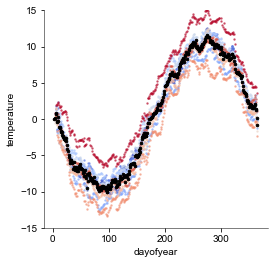

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(4,4))
plot_stratpd(X, y, 'dayofyear', 'temperature', ax=ax,
             show_x_counts=False,
             yrange=(-15, 15),
             pdp_marker_size=3, slope_line_alpha=.8, n_trials=10)
plt.show()

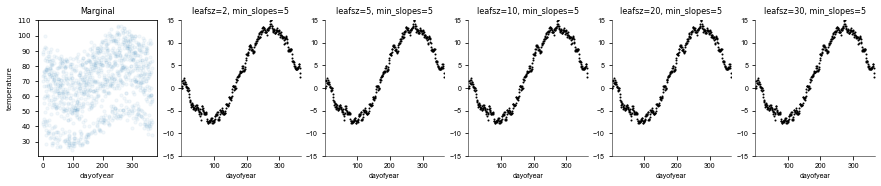

In [50]:
plot_stratpd_gridsearch(X, y, 'dayofyear', 'temperature',
             show_x_counts=False,
             yrange=(-15, 15))             
plt.show()

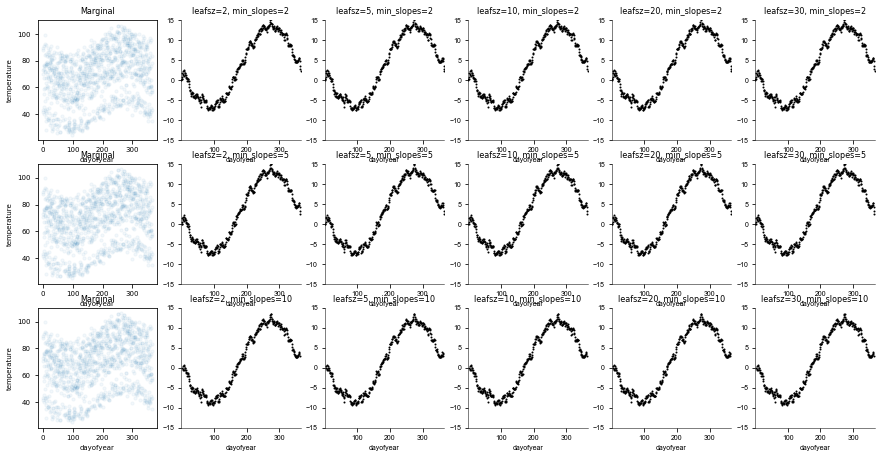

In [51]:
plot_stratpd_gridsearch(X, y, 'dayofyear', 'temperature',
             show_x_counts=False,
             min_slopes_per_x_values=[2,5,10],
             yrange=(-15, 15))             
plt.show()

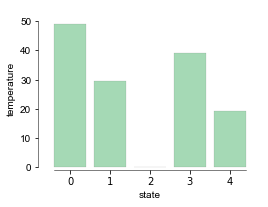

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))
plot_catstratpd(X, y, 'state', 'temperature', catnames=catnames,
                show_x_counts=False,
                min_y_shifted_to_zero=True,
                ax=ax,
                yrange=(-1, 55))
plt.show()

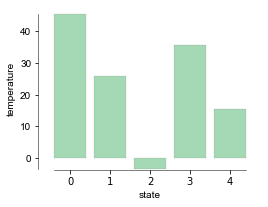

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(4,3))
plot_catstratpd(X, y, 'state', 'temperature', catnames=catnames,
                show_x_counts=False,
                min_y_shifted_to_zero=False,
                ax=ax,
               )
plt.show()